MAFS6001 Capstone: CTA strategy on Copper
==

1.Investigation Subject
---
The subject of this report is a summary of MAFS6001 capstone project in 2023 autumn, which mainly apply reasearches on the copper commodity to build an investing strategy.

2.Data sources
-----
The data used are composed by two part:
1. Copper commodity daily OHLC data(adjusted) provided by AQUMON, and the data is from Shanghai Futures Exchange.
2. Copper fundamental data, downloaded from WIND or caught by spyder from MacroMicro

3.Factors
---
We derive factors from fundamental data one by one, which means that we shift all factor in their own frequency to avoid messing up data with different frequency. The factors included: 
1. Future copper inventory in China(Day freq)
2. Copper inventory of COMEX(Day freq)
3. Copper inventory of LME in asia(Day freq)
4. Copper production amount of China(Month freq)
5. Imported Refined Copper production amount of China(Month freq) 

4.Model
---
In model selection procedure, I did some investigation testing and derive the appropriate model by exclusive method.
1. Basic model, like OLS. I generated 50+ factors from Ta-lib and selected the ones with highest IC. I put them into regression model with fundamental factors but received extraordinarily low R square.
2. Machine learning model, like LGBM. Considering the fact that LGBM model is based on tree model and we only have dozens of features, I unraveled data of factors in time series and combine data of 100 days in to a column and get thousands of feature. Unfortunately, the data in is daily frequency, which means that it has very limited samples, so our trained model is overfitting and received terrible result while predicting the future.  
3. Indicator. I generated some signals through basic combination of factors, and received good performance.

Finally I choosed the basic indicators as my model to avoid every possible point leading to overfitting effect, and the logic behind it could be well explained by common sense plus technical analysis. 


Signal selection

1. Market sentiment recognition:
    Bullish Sentiment Recognition:

    $ Price.std(long\_ term)<Price.std(long\_ term).mean(long\_ term)-Price.std(long\_ term).std(long\_ term)  \  \ 
    and \ \  Price>Price.shift(90) $

    Bearish Sentiment Recognition:

    $ Price.std(long\_ term)>Price.std(long\_ term).mean(long\_ term)+Price.std(long\_ term).std(long\_ term)  \  \ and \ \  Price<Price.shift(90) \ \ \ (for\ long\ signal) $

    Overreacted Sentiment Recognition:

    $ Price.std(long\_ term)<Price.std(long\_ term).mean(long\_ term)+Price.std(long\_ term).std(long\_ term)  \  \ and \ \  Price<Price.shift(90)\ \ \ (for\ short\ signal) $

    As the std of price gets down enough but the price is high than before, the market has already reached a consensus that the price will get   continuously higher. And when the market met slump, the volatility get higher while price get lower. Besides, the decrease from a bearish period leads to overreaction, and there should be chance for underlying asset price to get inversed with low std and low price

2. Trend following:
    midterm and short term upward/downward trend, which means that the price is higher/lower than rolling mean of former period(for long/short signal)
    midterm break signal, which means the price is higher than midterm before and form a breakthrough(for short signal)
    downward inversed signal, which means the close is higher than rolling min(avoid it for short signal) 

3. Fundamental factors:
    We differentiate the fundamental data, to get the change in the inventory amount, imported amount or production amount. If the inventory gets higher , the support is going up, implying decrease in price latter. Similarly, the imported copper and production follows the same logic.

    Considering that the fundamental factors we have are with different freq, we cannot used them in the same processing way, but we can use a simple indicator method to derive it. We judge whether the difference is larger than 0, and count the situations. If more than two conditions are satisfied, we regard it as an postive signal.

After selecting signals, we need to combine it.

1. Long: Overreaction, midterm up, short up, mid break 
2. Long: Fundamental, midterm up, short up, mid break. There are so many fundamental signal to long, and if we adopt them all we will receive a very high return with drawdown rate with the same magnitude, which we don't like. So we make some additional restrictions to it.
3. Short: No midterm inversion, bearish, mid down, short down 

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

#parameters
long_term=20
mid_term=10
short_term=5

#read data
data=pd.read_csv("CU0.SHF.csv", index_col=0).drop(columns=['Contract'])
external_data=pd.read_csv('modified_external_data.csv',encoding='utf-8',sep=',')
data.reset_index(inplace=True)
data=data.rename(columns={'index':'date','Open_adj':'open','High_adj':'high','Low_adj':'low','Close_adj':'close','Volume':'volume'})
data=data.drop(columns=['open','high','low','volume','Open_interest'])
data=pd.merge(data,external_data,on='date',how='left')

#generate basic signals
data['mid_break']=(data['close']>data['close'].shift(mid_term)).astype(int)
data['short_up']=(data['close']>data['close'].rolling(short_term).mean()).astype(int)
data['short_down']=(data['close']<data['close'].rolling(short_term).mean()).astype(int)
data['downward_inverse']=(data['close']>data['close'].rolling(mid_term).min()).astype(int)
data['mid_up']=(data['close']>data['close'].rolling(mid_term).mean()).astype(int)
data['mid_down']=(data['close']<data['close'].rolling(mid_term).mean()).astype(int)
data['vol_short']=data['close'].rolling(short_term).std()
data['vol_long']=data['close'].rolling(long_term).std()
data['vol_long_mean']=data['vol_long'].rolling(long_term).mean()
data['vol_long_std']=data['vol_long'].rolling(long_term).std()

data['sentiment_bullish']=(data['vol_long']<data['vol_long_mean']-data['vol_long_std'])*(data['close']>data['close'].shift(90)).astype(int)
data['sentiment_bearish']=(data['vol_long']>data['vol_long_mean']+data['vol_long_std'])*(data['close']<data['close'].shift(90)).astype(int)
data['sentiment_overreact']=(data['vol_long']<data['vol_long_mean']+data['vol_long_std'])*(data['close']<data['close'].shift(90)).astype(int)

data['spot_inventory_CN']=data['spot_inventory_CN']>0
data['inventory_COMEX']=data['inventory_COMEX']>0
data['inventory_LME_asia']=data['inventory_LME_asia']>0
data['production_CN']=data['production_CN']>0
data['import_refined_CN']=data['import_refined_CN']>0

#combine basic signals
data['long_signal']=(data['sentiment_overreact']*data['short_up']*data['mid_up'])*data['mid_break']+\
    (((1-data['spot_inventory_CN'])+(1-data['inventory_COMEX'])+(1-data['inventory_LME_asia'])   \
        +(1-data['production_CN'])+(1-data['import_refined_CN']))>2)*data['short_up']*data['mid_up']*data['mid_break']

data['short_signal']=(1-data['downward_inverse'])*data['sentiment_bearish']*data['short_down']*data['mid_down']

data=data[['date','close','long_signal','short_signal','vol_short','vol_long']]



5.Backtest
------
1. Basic assumption. Set commission at 0.02% and leverage rate is 0.25, initial margin 10_000_000.

2. We derive the long/short signal by the day, but we cannot get the full OHLC data until the day is passed. So we shift our signal to tomorrow.

3. We cannot always invest all money, so we Vol_long and Vol_short are volatility, and  put the quotient of them into sigmoid function.
    Generally, when vol is high we should invest less money. But our model is based on volatility, so we filter the samples with low relative volatility.

4. We check the signal row by row, if there is investment signal, we round the money with invest ratio to get position today.
   And we will hold the position til next day, so the change of margin happens on tomorrow opening. We modify margin tomorrow directly by calculating changes in price multiplied by position. Besides add commission fee.

5. The strategy is a kind of speculation. So we almost change position every day.

6. If long and short signal appear at the same time, just skip this day to avoid conflict.

In [14]:
#todya's signal is based on yesterday's data,and margin at the end of tommorw is only based on today's signal
data[['long_signal','short_signal','vol_short','vol_long']]=data[['long_signal','short_signal','vol_short','vol_long']].shift(1)
data['position']=0
data['margin']=10000000
margin_ratio=0.25
commission=0.0002
data=data.dropna()
data=data.reset_index(drop=True)
#avoid SettingWithCopyWarning
freeze_day=0
for i in range(1,data.shape[0]-1):
    invest_ratio=1/(1+np.exp(-data['vol_short'].iloc[i]/data['vol_long'].iloc[i]))    
    drawdown_ratio=1-data['margin'].iloc[i]/data['margin'].iloc[:i].max()
    if invest_ratio<0.6:
        position=0
        data.loc[i+1,'margin']=data['margin'].iloc[i]
    else:
        if data['long_signal'].iloc[i]>=1 and data['short_signal'].iloc[i]==0:
            position=int(data['margin'].iloc[i]*invest_ratio/margin_ratio/data['close'].iloc[i])
            data.loc[i+1,'margin']=data['margin'].iloc[i]+position*(data['close'].iloc[i+1]-data['close'].iloc[i])-commission*np.abs(position-data['position'].iloc[i-1])* data['close'].iloc[i]
        elif data['short_signal'].iloc[i]>=1:
            position=-int(data['margin'].iloc[i]*invest_ratio/margin_ratio/data['close'].iloc[i])
            data.loc[i+1,'margin']=data['margin'].iloc[i]+position*(data['close'].iloc[i+1]-data['close'].iloc[i])-commission*np.abs(position-data['position'].iloc[i-1])* data['close'].iloc[i]
        else:
            position=0
            data.loc[i+1,'margin']=data['margin'].iloc[i]
            
    data.loc[i,'position']=position
    
data

,date,close,long_signal,short_signal,vol_short,vol_long,position,margin
0,1/2/2010,54397.64725,0.0,0.0,1867.916877,1551.092400,0,1.000000e+07
1,2/2/2010,54297.61480,0.0,0.0,2305.922683,2028.624279,0,1.000000e+07
2,3/2/2010,55887.54496,0.0,0.0,2258.124863,2385.668508,0,1.000000e+07
3,4/2/2010,53997.62798,0.0,0.0,1304.631124,2477.777242,0,1.000000e+07
4,5/2/2010,51977.71671,0.0,0.0,815.561216,2709.777066,0,1.000000e+07
...,...,...,...,...,...,...,...,...
3164,14/2/2023,79736.15872,0.0,0.0,256.521580,972.867481,0,9.538523e+07
3165,15/2/2023,79689.71948,0.0,0.0,259.810790,784.969563,0,9.538523e+07
3166,16/2/2023,79538.79199,0.0,0.0,259.810790,751.552594,0,9.538523e+07
3167,17/2/2023,79968.35487,0.0,0.0,245.596144,757.286544,0,9.538523e+07


6.Performance
----

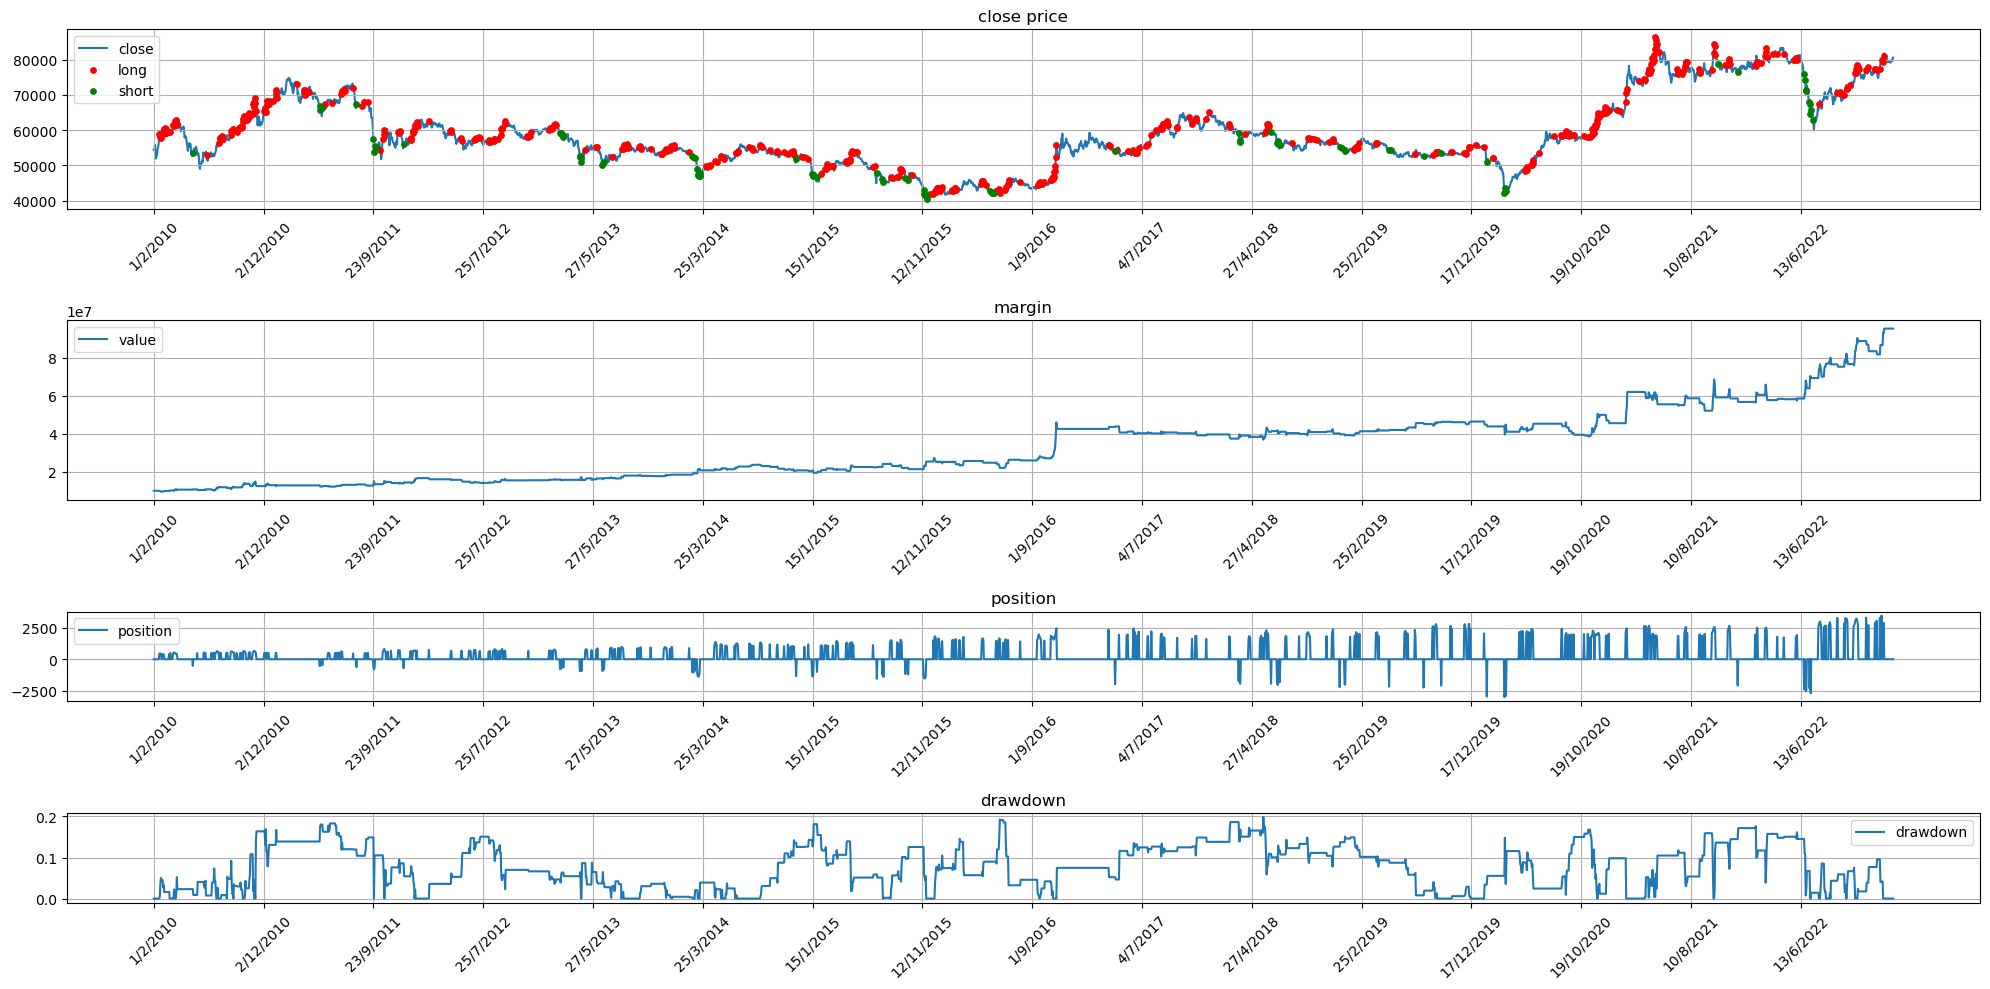

In [15]:
long_date=data[(data['long_signal']==1)]
short_date=data[(data['short_signal']==1)]
fig,ax=plt.subplots(4,1,figsize=(20,10),dpi=100,gridspec_kw={'height_ratios':[2,2,1,1]})
ax[0].plot(data['date'],data['close'],label='close',zorder=1)
ax[0].grid()
ax[0].set_xticks(data['date'][::200])
ax[0].set_xticklabels(data['date'][::200],rotation=45)
ax[0].scatter(long_date['date'],long_date['close'],label='long',s=15,color='red',zorder=2)
ax[0].scatter(short_date['date'],short_date['close'],label='short',s=15,color='green',zorder=3)
ax[0].legend()
ax[0].set_title('close price')
ax[1].grid()
ax[1].plot(data['date'],data['margin'],label='value')
ax[1].set_xticks(data['date'][::200])
ax[1].set_xticklabels(data['date'][::200],rotation=45)
ax[1].legend()
ax[1].set_title('margin')
ax[2].grid()
ax[2].plot(data['date'],data['position'],label='position')
ax[2].set_xticks(data['date'][::200])
ax[2].set_xticklabels(data['date'][::200],rotation=45)
ax[2].legend()
ax[2].set_title('position')
ax[3].grid()
ax[3].plot(data['date'],(np.maximum.accumulate(data['margin'])-data['margin'])/np.maximum.accumulate(data['margin']),label='drawdown')
ax[3].set_xticks(data['date'][::200])
ax[3].set_xticklabels(data['date'][::200],rotation=45)
ax[3].legend()
ax[3].set_title('drawdown')
plt.tight_layout()
plt.show()

In [16]:
print("annual return:\t",(data['margin'].iloc[-1]/data['margin'].iloc[0])**(1/13)-1)
print("max drawdown:\t",np.max((np.maximum.accumulate(data['margin'])-data['margin'])/np.maximum.accumulate(data['margin'])))
print("winning rate:\t",np.sum(data['margin'].iloc[1:].values>data['margin'].iloc[:-1])/np.sum(data['margin'].iloc[1:].values!=data['margin'].iloc[:-1]))
daily_return=(data['margin'].iloc[1:].values-data['margin'].iloc[:-1])/data['margin'].iloc[:-1]
print("sharp ratio:\t",np.mean(daily_return)/np.std(daily_return)*np.sqrt(252))

annual return:	 0.18944592100645408
max drawdown:	 0.19872638790198582
winning rate:	 0.5212418300653595
sharp ratio:	 0.8422027247155734


7.Summary
---
The copper CTA strategy receive 19% rate of return annually and the max drawdown rate is limited under 20%.

In the project, I managed to apply reasonable and simple sense on the strategy, avoiding the complex function and overfitting possibilities. During this period, I have done a lot of tests and attempts, and construct the whole process of this strategy simplified all trivial extensions, left with a bulk strategy.

But I don't think this indicator strategy is a mature idea, and it is just a kind of compromise under such situation with limited data and time. 

There are some difficulties to build up a strategy on copper commodity. 

1. Only one underlying asset. So we can hardly compute section IC on the time series. Traditional IC, even adjusted by Newey-West estimator, is not an appropriate criterion to select factors. 
2. Low frequency of data. In my former experience, with tick-level data, we can catch the features in micro structure more easily. And with such large amount of data, machine learning or deep learning are useful to catch the trading signal.
3. Lacking an effective method to control loss and position. This idea is full of speculation, holding no more than one day for every opened interest, thus traditional risk management doesn't work out.
